#### Necessary Imports & Installs

In [9]:
#!pip install graphviz
#!pip install torch

In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import random

#### Building Value Data Structure for the AutoGrad Engine

In [11]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other 
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1) 
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
    
        return out

    def sigmoid(self):
        x = self.data
        t = 1 / (1 + math.exp(-x)) 
        out = Value(t, (self, ), 'sigmoid')
        
        def _backward():
            self.grad += t * (1 - t) * out.grad
        out._backward = _backward
    
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
    
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def __repr__(self):
      """How the 'print' function displays our object"""
      return f"Value(data={self.data}, label={self.label})"

#### Visualizing our entire $NN$ expression

In [12]:
from graphviz import Digraph

def trace(root):
    '''Builds a set of all nodes and edges in a graph'''
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # creating a rectangular 'record' node for every value in the graph
        dot.node(name=uid, label=f"{n.label}|data:{n.data: .4f}|grad:{n.grad: .4f}", shape='record')
        if n._op:
            #if the value is resulting from some operation, (not a leaf node)
            dot.node(name=uid+n._op, label = n._op)
            dot.edge(uid+n._op,uid) #connect this op node to the resulting node
    for n1, n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
    return dot

#### Example of a single neuron

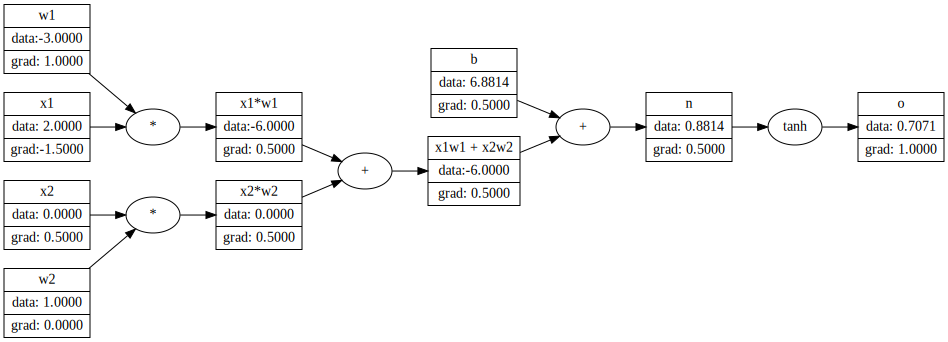

In [15]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'
o.backward()
draw_dot(o)



#### Building out Neural Network Module

In [16]:
class Neuron:
  def __init__(self, num_of_inputs):
      self.w = [Value(random.uniform(-1,1)) for _ in range(num_of_inputs)]
      self.b = Value(random.uniform(-1,1))

  def __call__(self, x) -> Value:
    act = sum((xi*wi for xi, wi in zip(x, self.w)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

  def __repr__(self) -> str:
    out = self.__call__(x)
    return f"Value(data={out.data})"

class Layer:
  def __init__(self, num_of_inputs, num_of_outputs):
      self.neurons = [Neuron(num_of_inputs) for _ in range(num_of_outputs)]

  def __call__(self, x):
      outs = [n(x) for n in self.neurons]
      return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, num_of_inputs, list_of_outputs):
    sz = [num_of_inputs] + list_of_outputs
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(list_of_outputs))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [17]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [18]:
n = MLP(3, [4,4,1])
for k in range(1000):
  # feed forward
  y_pred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for (yout, ygt) in zip(y_pred, ys))

  # Back propagation
  for p in n.parameters():
    p.grad = 0
  loss.backward()

  #Gradient descent
  for p in n.parameters():
    p.data += -0.05*p.grad

print(f'Actual Output: {ys}')
print(f'Predicted Output: {y_pred}')
print(f'Loss: {loss}')

Actual Output: [1.0, -1.0, -1.0, 1.0]
Predicted Output: [Value(data=0.9899171200187833, label=), Value(data=-0.9886567073090763, label=), Value(data=-0.9850515116396992, label=), Value(data=0.9906082627819109, label=)]
Loss: Value(data=0.0005419967900192724, label=)


#### Doing the Same with pytorch

In [ ]:
x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()

print('-------')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

###### credits: https://www.youtube.com/watch?v=VMj-3S1tku0&t=1741s